In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm

from DynamicalSystemLayer import *
from VaeNeuralODELayer import *

# Data generation

In [4]:
p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,100))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)

In [5]:
obs.shape

torch.Size([100, 2])

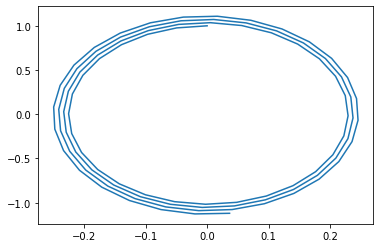

In [7]:
plt.plot(obs[:,0].detach().numpy(), obs[:,1].detach().numpy())
plt.show()

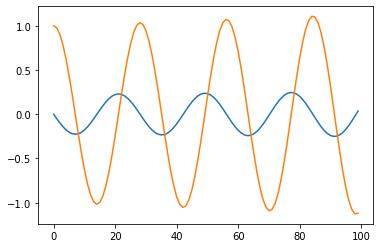

In [6]:
plt.plot(obs[:,0].detach().numpy())
plt.plot(obs[:,1].detach().numpy())
plt.show()

In [96]:
pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)

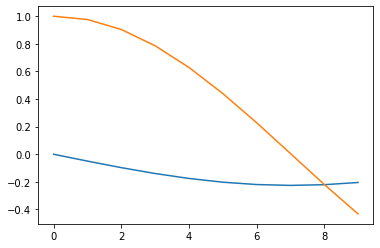

In [62]:
pend_data = obs
window_len = 5
window_set2 = pend_data.view(20, 10, 2)
times_set2 = times.view(20, 10)

plt.plot(window_set2[0,:,0].detach().numpy())
plt.plot(window_set2[0,:,1].detach().numpy())
plt.show()

In [95]:
x = torch.randn(200,2)
y = x.view(40, 5, 2)
y[0,0]

tensor([ 0.2651, -1.1379])

In [97]:
window_set.shape

torch.Size([40, 5, 2])

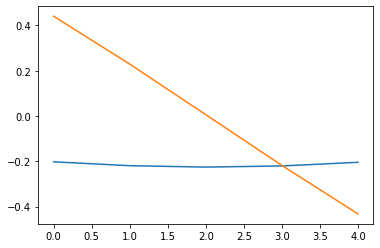

In [100]:
plt.plot(window_set[1,:,0].detach().numpy())
plt.plot(window_set[1,:,1].detach().numpy())
plt.show()

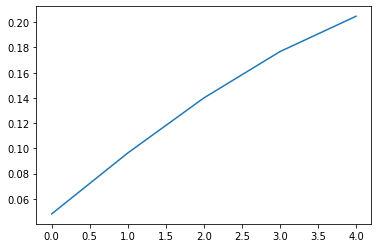

In [6]:
plt.plot(window_set[3,:,0].detach().numpy())
#plt.plot(window_set[1,:,1].detach().numpy())
plt.show()

# Model

In [ ]:
def Dynamical_System_Layer(nn.Module):
    def forward_grad(self, z, t, grad_out):
        out = self.forward(z, t)
        
        a = grad_out
        adfdp = torch.autograd.grad(out, tuple(self.parameters()), grad_outputs=a, allow_unused=True, retain_graph=True)
        
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
            
        return adfdp
    
    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)
    
    
class Dynamical_System_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        z_dim = z0.size(0)
        time_len = t.size(0)
        
        z = torch.zeros(time_len, z_dim)
        z[0] = z0
        
        for it in range(time_len - 1):
            z0 = ode_solve(z0, t[it], t[it+1], func)
            z[it+1] = z0
            
        ctx.save_for_backward(flat_parameters, z.clone(), t)
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        flat_parameters, z, t = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        a = grad_out.clone()
        n_param = a.shape[1]
        
        grad_weight = torch.zeros(z_dim, n_param)
        
        for it in range(time_len - 1, 1, -1):
            zi = z[it-1].view(1, z_dim)
            ti = t[it]
            ai = a[it].view(1, n_param)
            dzdpi = func.forward_grad(zi, ti, ai)
            
            grad_weight += dzdpi
        return grad_weight
        

In [99]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight.reshape(2,2))
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        

In [100]:
class DynamicalSystemModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(DynamicalSystemModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out

# Training

In [10]:
kk = 0.01
AA = np.asarray([[1,1],[-kk,1]])

sol = [[0.99,1]]
for i in range(100):
    sol.append(np.dot(np.asarray(sol[-1]),AA))
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([100, 2])
train_y.shape: torch.Size([100, 2])


Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.6527, -0.1352],
        [ 0.1063, -0.1045]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9985,  0.9951],
        [-0.0100,  1.0000]], requires_grad=True)]


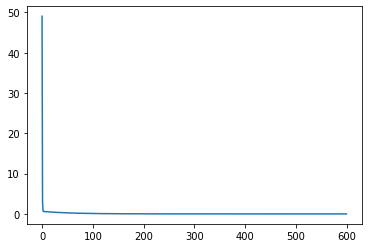

In [87]:
model = DynamicalSystemModel(2, 2)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.3494, -0.3313],
        [ 0.2877,  0.0876]], requires_grad=True), Parameter containing:
tensor([ 0.1935, -0.3272], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9935,  0.9922],
        [-0.0099,  1.0002]], requires_grad=True), Parameter containing:
tensor([-0.0030, -0.0051], requires_grad=True)]


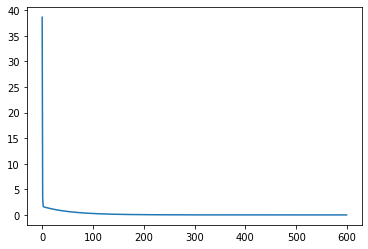

In [101]:
#with bias
model = DynamicalSystemModel(2, 2, True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()